In [1]:
using Pkg; Pkg.activate("."); Pkg.instantiate()

 Activating environment at `~/Documents/kubo_analysis_julia/notebook/Project.toml`


## 9 GLMのベイズモデル化と事後分布の推定
GraphViz はJulia 1.0をサポートしていないため、ForneyLabを使う

In [2]:
using CSV
using DataFrames
using ForneyLab
using GLM
using LaTeXStrings
using LinearAlgebra
using Mamba
using Plots
using Random
Random.seed!(0)

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/matsueushi/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


MersenneTwister(UInt32[0x00000000], Random.DSFMT.DSFMT_state(Int32[748398797, 1073523691, -1738140313, 1073664641, -1492392947, 1073490074, -1625281839, 1073254801, 1875112882, 1073717145  …  943540191, 1073626624, 1091647724, 1073372234, -1273625233, -823628301, 835224507, 991807863, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000

In [3]:
df = CSV.read(joinpath("..", "data/section9.csv"))
disallowmissing!(df)

,x,y
,Float64,Int64
1,3.0,5
2,3.21053,3
3,3.42105,6
4,3.63158,7
5,3.84211,7
6,4.05263,5
7,4.26316,9
8,4.47368,9
9,4.68421,7


## 9.1 例題 : 種子数のポアソン回帰 (個体差なし)

In [4]:
glm_model = glm(@formula(y ~ x), df, GLM.Poisson())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Poisson{Float64},LogLink},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────────
              Estimate  Std. Error  z value  Pr(>|z|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  1.56606     0.359949   4.35077    <1e-4    0.860569    2.27154
x            0.0833412   0.0683847  1.21871    0.2230  -0.0506904   0.217373
────────────────────────────────────────────────────────────────────────────

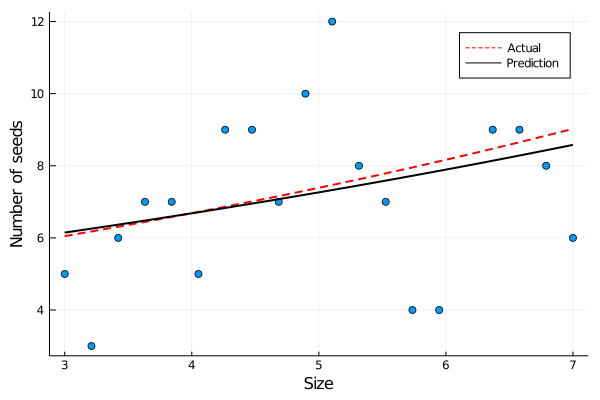

In [5]:
scatter(df.x, df.y, label="", xlabel="Size", ylabel="Number of seeds")
xs = 3:0.1:7
xx = DataFrame(x=xs)
plot!(xs, exp.(1.5 .+ 0.1 .* xs), label="Actual", linewidth=2,
    linestyle=:dash, linecolor=:red)
plot!(xs, predict(glm_model, xx), label="Prediction", linewidth=2,
    linecolor=:black)

## 9.4 ベイズ統計モデルの事後分布の推定
### 9.4.1 ベイズ統計モデルのコーディング
$$\begin{align} y_i \sim \text{Poisson}(\lambda_i)\\
\log(\lambda_i) = \beta_1 + \beta_2 \cdot x_i\\
\beta_1 \sim \text{Normal}(0, 100^2)\\
\beta_2 \sim \text{Normal}(0, 100^2) \end{align}$$

Mamba.jl ( https://mambajl.readthedocs.io/ )を使う
### モデルの作成

In [6]:
model = Model(
    y = Stochastic(1,
        (N, lambda) ->
        (UnivariateDistribution[Mamba.Poisson(lambda[i]) for i in 1:N]),
        false
    ),

    lambda = Logical(1,
        (x, beta) -> exp.(x * beta)
    ),

    beta = Stochastic(1,
        () -> MvNormal(2, 100)
    ),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


### モデルをプロットする

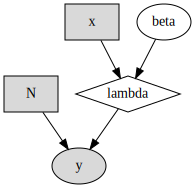

In [7]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model)))

### データの設定

In [8]:
data = Dict{Symbol, Any}(
    :x => [ones(length(df.x)) df.x],
    :y => df.y[:],
    :N => length(df.x)
)

Dict{Symbol,Any} with 3 entries:
  :N => 20
  :y => [5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6]
  :x => [1.0 3.0; 1.0 3.21053; … ; 1.0 6.78947; 1.0 7.0]

### 初期値の設定

In [9]:
inits = [
    Dict{Symbol, Any}(
        :y => df.y[:],
        :beta => zeros(2),
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta => [0.0, 0.0],:y => [5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6])
 Dict(:beta => [0.0, 0.0],:y => [5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6])
 Dict(:beta => [0.0, 0.0],:y => [5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6])

### サンプラーの設定

In [10]:
scheme = [NUTS([:beta])]

1-element Array{Sampler{Mamba.NUTSTune},1}:
 An object of type "Sampler{Mamba.NUTSTune}"
Sampling Block Nodes:
[:beta]

CodeInfo(
1 ─ %1 = π (Mamba.var"#271#273"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{,Tuple{}}}}(:forward, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{,Tuple{}}}()), Core.Compiler.Const(Mamba.var"#271#273"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{,Tuple{}}}}(:forward, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{,Tuple{}}}()), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


### MCMCシミュレーション

In [11]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 1600, burnin=100, thin=3, chains=3)

MCMC Simulation of 1600 Iterations x 3 Chains...

Chain 1:   1% [0:02:37 of 0:02:38 remaining]
Chain 1:  10% [0:00:13 of 0:00:14 remaining]
Chain 1:  20% [0:00:06 of 0:00:08 remaining]
Chain 1:  30% [0:00:04 of 0:00:06 remaining]
Chain 1:  40% [0:00:03 of 0:00:05 remaining]
Chain 1:  50% [0:00:02 of 0:00:04 remaining]
Chain 1:  60% [0:00:01 of 0:00:04 remaining]
Chain 1:  70% [0:00:01 of 0:00:03 remaining]
Chain 1:  80% [0:00:01 of 0:00:03 remaining]
Chain 1:  90% [0:00:00 of 0:00:03 remaining]
Chain 1: 100% [0:00:00 of 0:00:03 remaining]

Chain 2:   1% [0:00:01 of 0:00:01 remaining]
Chain 2:  10% [0:00:01 of 0:00:01 remaining]
Chain 2:  20% [0:00:01 of 0:00:02 remaining]
Chain 2:  30% [0:00:01 of 0:00:02 remaining]
Chain 2:  40% [0:00:01 of 0:00:02 remaining]
Chain 2:  50% [0:00:01 of 0:00:02 remaining]
Chain 2:  60% [0:00:01 of 0:00:02 remaining]
Chain 2:  70% [0:00:01 of 0:00:02 remaining]
Chain 2:  80% [0:00:00 of 0:00:02 remaining]
Chain 2:  90% [0:00:00 of 0:00:02 remaining]
Chai

Object of type "ModelChains"

Iterations = 103:1600
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 500

[2.1416456862181596 -0.034195462896480594 … 6.749554419388481 6.701138557686226; 2.118099617290033 -0.017317501166503175 … 7.392920838167144 7.36601687627399; … ; 2.008474283213537 -0.004607765210916916 … 7.222419319439668 7.215416566523935; 2.007108804781768 -0.03046053297814351 … 6.051449424939966 6.01276719243536]

[1.7664072006151288 0.058901939921014945 … 8.726116030012893 8.834997122357686; 1.6886231271090701 0.0747166950796646 … 8.988178034274595 9.13067836648673; … ; 1.6010919695071681 0.05854124666989085 … 7.378395648766207 7.469893157740115; 1.6171654574735304 0.07188247286725936 … 8.208823524779119 8.333993620692839]

[1.132040524506239 0.1596661888076778 … 9.17139968178182 9.484926422987341; 1.392813256217645 0.14247530651875648 … 10.592493612279473 10.915026325342115; … ; 1.5325060417095706 0.08215997411883304 … 8.087575732171931 8.22868203690689; 1.65064422425

### 9.4.3 どれだけ長くMCMCサンプリングすればいいのか？

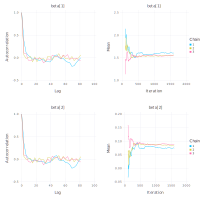

In [12]:
p = Mamba.plot(sim[:, :beta, :], [:autocor, :mean], legend=true)
Mamba.draw(p, nrow=2, ncol=2)

### Gelman-Rubin diagnostic ($\hat{R}$)の推定値

In [13]:
gelmandiag(sim[:, :beta, :], mpsrf=true, transform=true)

              PSRF 97.5%
     beta[1] 1.004 1.017
     beta[2] 1.006 1.024
Multivariate 1.021   NaN



## 9.5 MCMCサンプルから事後分布を推定¶
### シミュレーション結果の表示と図示

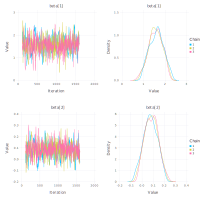

In [14]:
p = Mamba.plot(sim[:, :beta, :], legend=true)
Mamba.draw(p, nrow=2, ncol=2)

### 9.5.1 事後分布の統計量

In [15]:
describe(sim[:, :beta, :])

Iterations = 103:1600
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 500

Empirical Posterior Estimates:
            Mean        SD       Naive SE       MCSE     ESS
beta[1] 1.571184138 0.36903218 0.0095283700 0.0150866535 500
beta[2] 0.081357021 0.06970258 0.0017997128 0.0029171675 500

Quantiles:
            2.5%       25.0%      50.0%       75.0%      97.5%  
beta[1]  0.80168740 1.33071546 1.585494139 1.81834773 2.28139226
beta[2] -0.05404298 0.03375535 0.080038025 0.12714997 0.22335777



In [16]:
xs = collect(3:0.1:7)
xs_mat = [ones(length(xs)) xs]

sim_beta = sim[:, [:beta], :].value
sim_beta = reshape(permutedims(sim_beta, (2, 1, 3)), size(sim_beta, 2), :)

2×1500 Array{Float64,2}:
  2.14165     2.1181     1.90173    …  1.59677    1.53251  1.65064
 -0.0341955  -0.0173175  0.0252473     0.0892052  0.08216  0.0594285

In [17]:
beta_median = vec(mapslices(median, sim[:, [:beta], :].value, dims=(1,3)))

2-element Array{Float64,1}:
 1.5854941392012076
 0.08003802478403144

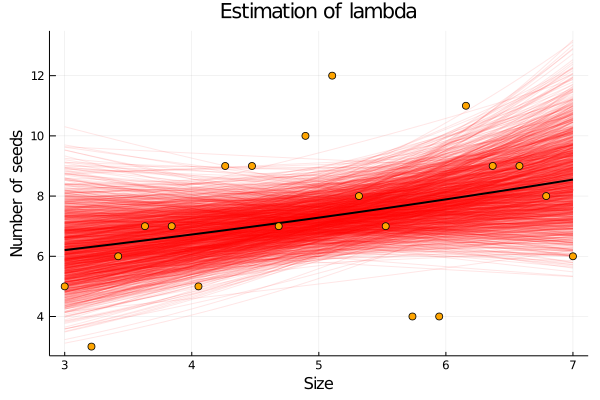

In [18]:
Plots.plot(xs, exp.(xs_mat * sim_beta), label="", linecolor=:red, linealpha=0.1)
Plots.plot!(xs, exp.(xs_mat * beta_median), label="",
            linewidth=2, linecolor=:black)
scatter!(df.x, df.y,
    label="",
    markercolor=:orange,
    xlabel="Size", ylabel="Number of seeds",
    title="Estimation of lambda")

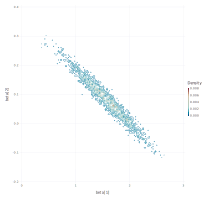

In [19]:
p = Mamba.plot(sim[:, :beta, :], :contour)
Mamba.draw(p, nrow=1, ncol=1)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*